In [1]:
import math
import nltk
import scipy
import string
import re
import numpy as np
import pandas as pd
import seaborn as sns
import operator
import text2emotion as te

from tqdm import tqdm
from scipy.stats import randint
from wordcloud import WordCloud
from multiprocessing import Pool
from nltk.corpus import stopwords
from scipy.stats import loguniform

from nltk.stem.porter import PorterStemmer
import lightgbm as lgb
import matplotlib.pyplot as plt
from IPython.display import display
plt.rcParams['figure.figsize'] = [20,6]
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
import warnings 
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Data Preprocessing

In [2]:
df = pd.read_csv('Tweets.csv', header=0)

In [3]:
df.drop(['selected_text', 'textID'], axis=1, inplace=True)

In [4]:
df.dropna(inplace=True)
second_df = df.copy(deep=True)
second_df

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative
...,...,...
27476,wish we could come see u on Denver husband l...,negative
27477,I`ve wondered about rake to. The client has ...,negative
27478,Yay good for both of you. Enjoy the break - y...,positive
27479,But it was worth it ****.,positive


In [5]:
df_nodup = df.drop_duplicates()
df_nodup.reset_index(drop=True, inplace=True)

In [6]:
counter = 0
r,c = second_df.shape

df_nodup = df.drop_duplicates()
df_nodup.reset_index(drop=True, inplace=True)

In [7]:
df_filter = df_nodup.copy()

def preprocessor(text):
    text = re.sub('[^a-zA-Z]',' ',text)
    text = text.lower()
    text = text.strip()
    text = ''.join([i for i in text if i in string.ascii_lowercase+' '])
    text = ' '.join([word for word in text.split() if word.isalnum()])
    text = ' '.join([WordNetLemmatizer().lemmatize(word,pos='v') for word in text.split()])    
    text = ' '.join([word for word in text.split() if word not in stopwords.words('english')])
    return text

In [8]:
df_filter['text'] = df_nodup['text'].apply(preprocessor)

df_filter.head()

,text,sentiment
0,respond go,neutral
1,sooo sad miss san diego,negative
2,boss bully,negative
3,interview leave alone,negative
4,sons put release already buy,negative


In [9]:
porter=PorterStemmer()
target = 'sentiment'
def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

In [10]:
df_vector=TfidfVectorizer(strip_accents=None,lowercase=False,preprocessor=None,tokenizer=tokenizer_porter,use_idf=True,norm='l2',smooth_idf=True)
label=df_filter[target].values
features=df_vector.fit_transform(df_filter.text)
features

<27480x19389 sparse matrix of type '<class 'numpy.float64'>'
	with 191163 stored elements in Compressed Sparse Row format>

### Detecting most occured work in a particular sentiment

In [11]:
neut_df = second_df[second_df[target]=='neutral']['text']
pos_df = second_df[second_df[target]=='positive']['text']

neg_df = second_df[second_df[target]== 'negative']['text']

In [12]:
def freq_text(text_df):     # returns all occurences of words in text_df
 
    combi_text=""
    for x in text_df.values:
        combi_text+=' '.join(x.split())
    combi_text  = [x for x in combi_text.split() if len(x) >3 and x not in stopwords.words('english')]  
    return combi_text

In [13]:
def freq_df(text_count_df,senti):    # returns the count of each word in text_count_df obtained from previous function
    fredis = nltk.FreqDist(neut_text)
    fredis_df = pd.DataFrame({senti: list(fredis.keys()),
                      'Count': list(fredis.values())})
    fredis_df = fredis_df.sort_values(by='Count',ascending=False)
    return fredis_df

In [18]:
neut_df = neut_df.apply(preprocessor)
sen = 'Neutral'
neut_text = freq_text(neut_df)
neut_freq_df = freq_df(neut_text,sen)

,Neutral,Count
58,http,453
85,like,409
119,work,397
164,time,327
334,back,313
...,...,...
7787,pudding,1
7788,playoff,1
7789,partwake,1
7791,creepyjune,1


In [19]:
pos_df = pos_df.apply(preprocessor)
sen = 'Positive'
pos_text = freq_text(pos_df)
pos_freq_df = freq_df(pos_text,sen)

,Positive,Count
58,http,453
85,like,409
119,work,397
164,time,327
334,back,313
...,...,...
7787,pudding,1
7788,playoff,1
7789,partwake,1
7791,creepyjune,1


In [20]:
neg_df = neg_df.apply(preprocessor)
sen = 'Negative'
neg_text = freq_text(neg_df)
neg_freq_df = freq_df(neg_text,sen)

,Negative,Count
58,http,453
85,like,409
119,work,397
164,time,327
334,back,313
...,...,...
7787,pudding,1
7788,playoff,1
7789,partwake,1
7791,creepyjune,1


In [44]:
def wordcloud_draw(data, color, s):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split() if(word!='movie' and word!='film')])
    wordcloud = WordCloud(stopwords=stopwords.words('english'),background_color=color,width=2500,height=2000).generate(cleaned_word)
    plt.imshow(wordcloud)
    plt.title(s)
    plt.axis('off')

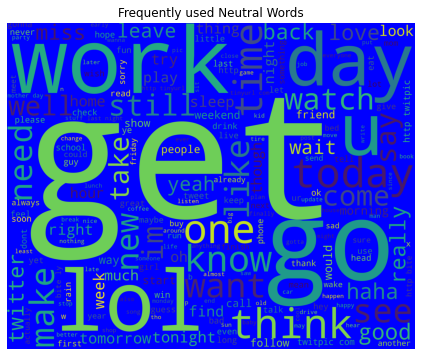

In [30]:
wordcloud_draw(neut_df, 'blue', 'Frequently used Neutral Words')

In [17]:
li_neut = ['😌','😉','🤗','🙄','🙂','😐','😑','work', 'day', 'one', 'know', 'want', 'find', 'see', 'haha', 'lol', 'make', 'week', 'much', 'need', 'well', 'take', 'wait', 'day', 'back', 'look', 'leave', 'well', 'home', 'still', 'show', 'ye', 'away', 'phone', 'think', 'get', 'I miss you']

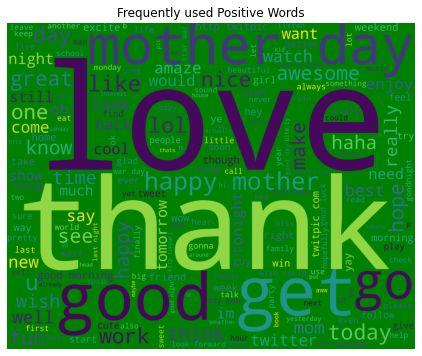

In [31]:
wordcloud_draw(pos_df, 'green', 'Frequently used Positive Words')

In [20]:
li_pos = ['😀','😁','😂','🤣','😃','😄','😆','😋','😎','🙂','love', 'happy', 'thank', 'mother', 'day', 'good', 'get', 'get', 'go', 'today', 'work', 'twitter', 'really', 'sleep', 'see', 'say', 'night', 'tomorrow']

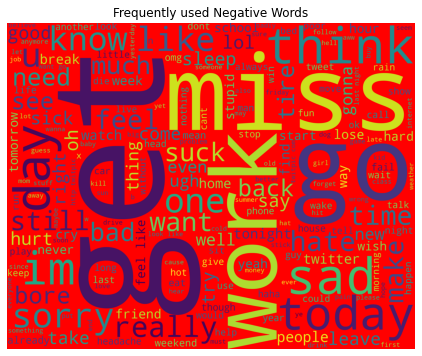

In [149]:
wordcloud_draw(neg_df, 'red', 'Frequently used Negative Words')

In [21]:
li_neg = ['😠','😒','😡','💢','🗯','👿','kill', 'murder','die', 'you will die', 'will kill you', 'will rape you', 'you will be raped', 'suicide', 'rape', 'kill yourself', 'fuck', 'get', 'miss', 'think', 'sad', 'go', 'sorry', 'today', 'really', 'hate', 'lol', 'sick', 'suck', 'feel']

### Syntactic Detection

In [5]:
with open('full-list-of-bad-words_comma-separated-text-file_2022_05_05.txt', 'r') as foul_words:
    foul = foul_words.read()

In [6]:
foul_li = foul.split(',')
for word in foul_li:
    word.strip

In [7]:
def detect_foul(word):
    word.lower()
    if word in foul_li:
        return True
    return False

def foul_density(text):
    cnt=0
    li = text.split()
    li = [word.lower() for word in li]
    length = len(li)
    for word in li:
        if word in foul_li:
            cnt+=1
    return (cnt/length)*100

In [8]:
def all_upper(word):
    return word.isupper()

def upper_density(text):
    cnt=0
    li = text.split()
    length = len(li)
    for word in li:
        if all_upper(word):
            cnt+=1
    return (cnt/length)*100;

In [9]:
def badness_of_sentence(text):
    rat = int(foul_density(text))
    up = int(upper_density(text))
    
    if up<50:
        if rat>=70:
            return 0   #High
        elif rat>=30 and rat<70:
            return 30  #Medium
        else:
            return 80  #Low
    else:
        if rat>=50:
            return 0   #High
        else:
            return 80  #Low

### Emotion Detection

In [10]:
def get_emotion(text):
    dict = te.get_emotion(text)
    max_key = max(dict, key=dict.get)
    return max_key

### String matching

In [11]:
def lesser(neut, pos, neg):
    least = "Neutral"
    if (neut <= pos) and (neut <= neg):
       least = 'Neutral'
    elif (pos <= neut) and (pos <= neg):
       least = 'Positive'
    else:
       least = 'Negative'
    return least

In [12]:
def larger(neut, pos, neg):
    largest = "Neutral"
    if (neut >= pos) and (neut >= neg):
       largest = 'Neutral'
    elif (pos >= neut) and (pos >= neg):
       largest = 'Positive'
    else:
       largest = 'Negative'
    return largest

In [13]:
def get_sentiment(text, cnt_neut=0, cnt_pos=0, cnt_neg=0, index_pos=0, index_neg=0, index_neut=0):
    if '.' in text:
        te = text.split('.')
    else:
        te = text
    for sentence in te:
        words = sentence.split()
        for word in words:
            if word in li_pos:
                index_pos = li_pos.index(word)
            elif word in li_neg:
                index_neg = li_neg.index(word)
            elif word in li_neut:
                index_neut = li_neut.index(word)
            else:
                index_neut = len(li_neut)+1
            least = lesser(index_neut, index_pos, index_neg)
            if least=="Neutral":
                cnt_neut+=1
            elif least=="Positive":
                cnt_pos+=1
            else:
                cnt_neg+=1
    return larger(cnt_neut, cnt_pos, cnt_neg)

### Threat %

In [14]:
def threat_percentage(text):
    badness = badness_of_sentence(text)
    emotion = get_emotion(text)
    emotion_cnt=0
    sentiment = get_sentiment(text)
    sentiment_cnt=0
    if emotion.lower()=='happy':
        emotion_cnt = 100
    elif emotion.lower()=='sad':
        emotion_cnt = 50
    elif emotion.lower()=='excited':
        emotion_cnt = 70
    elif emotion.lower()=='angry':
        emotion_cnt = 0
        
    if sentiment.lower()=='postive':
        sentiment_cnt = 100
    elif sentiment.lower()=='negative':
        sentiment_cnt = 0
    else:
        sentiment_cnt = 50
    
    return (100 - (badness+emotion_cnt+sentiment_cnt)/3)

In [15]:
def threshold_percentage(text):
    threshold = 75
    if threat_percentage(text) > 50:
        return True
    else:
        return False

In [16]:
text = input("Enter the text you want to test for threat percentage: ")
print("Threat Percentage: ", threat_percentage(text), "%", sep="")
th = threshold_percentage(text)
if(th==True):
    print("Blocking User...")
else:
    print("Safe to go!")

Enter the text you want to test for threat percentage: I will kill you
Threat Percentage: 56.666666666666664%
Blocking User...
